# Community detection

**Community detection** is the process of dividing a network into **communities**, where each community is some subset of nodes which connect more within community than without.
This is an old and famous network science problem. It has applications across a wide
range of disciplines. To name a just a few:
- Predicting "workgroups" in organizational communication networks {cite}`zuzul2021dynamic`
- Grouping researchers into fields based on networks of collaboration {cite}`girvan2002community`
- Clustering networks formed by nearest neighbors in high-dimensional data

Much of the discussion/derivation in this notebook is based on Sections 7.7 and 14.2 
from Mark Newman's "Networks" {cite:p}`newman2018networks`. 

## Modularity

From [Wikipedia](https://en.wikipedia.org/wiki/Modularity), in general usage, "modularity is the degree to which a system's components may be separated and recombined." The [definition in network science](https://en.wikipedia.org/wiki/Modularity_(networks)) is similar in spirit but has a more specific meaning. In words, **modularity** it is "the strength of division of a network into modules (also called groups, clusters or communities). Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules."

How do we write this down mathematically? To begin, lets consider an *undirected, unweighted* network with no loops, with $n \times n$ adjacency matrix $A$.

As usual, we'll let $k$ be an $n$-length vector with the degree of each node. $m$ will be the total number of edges.
<!-- 
First, we'll create a matrix $B$ defined as

$$B_{ij} = A_{ij} - \frac{k_i}{k_j}{2m}$$ -->

First, we'd like some way of measuring the strength of edges within groups. Let $\delta(\tau_i, \tau_j)$ be an indicator function which is
1 if $i$ and $j$ are in the same group, and 0 otherwise. Then, the total number of within-community edges is: 

$$\frac{1}{2} \sum_{i,j} A_{ij} \delta(\tau_i, \tau_j)$$

Note that we include the factor of $\frac{1}{2}$ because otherwise edges would be counted twice in the sum.

Now, we want to optimize some function of the expression above, but note that as written, we could trivially put
all nodes in the same group and that would maximize the expression we have written. So, we are going to add a term
that will balance how many edges are within a group by how many edges we'd expect within a group based on a random model. 

Specifically, we'll use the random model where each node has its observed degree ($k_i$), 
but edges are arranged at random. How many edges are expected between nodes under this model?

Consider node $i$ for the moment, and lets compute the probability of a particular 
edge $(i,j)$. Let's select *one* of the edges attached to $i$. Note that there are 
$2m-1$ remaining edge stubs (sometimes called half 
edges) in the network. If the wiring is random, then the probability of connecting to 
any other edge stub is the same. Therefore, the probability of connecting to node $j$ is
proportional to the degree of that node: $\frac{k_j}{2m-1}$. This is the
probability of the original half-edge we chose being connected to $j$, but *any* half-edge
connected to $i$ could have made the edge $(i, j)$. And how many of these half-edges
are there? $k_i$ of them. Therefore, the overall
probability that $i$ is connected to $j$ is $\frac{k_i k_j}{2m-1}$. Usually since $m$ is 
so large for most networks, we drop the $-1$ and consider

$$P_{ij} = \frac{k_i k_j}{2m}$$

```{note}
In the logic above, we omit some details about multiple edges between the same pair
of nodes under this random model, and the possibility of loops. Like the issue of $2m$
vs. $2m-1$, these details are negligible as the number of edges/nodes get large, so
we ignore them for simplicity.
```

Great, this is roughly the probability of the edge $(i, j)$, but recall that we were 
interested in something like "given a partition $\tau$ of my network, how many edges
should I expect to be within-group under this silly null model?". Using the same logic
as before, we can compute this expected value by summing over this expected probability
matrix.

$$\frac{1}{2} \sum_{ij} \frac{k_i k_j}{2m}$$

Going back to our original expression, we literally take the difference of the observed
number of edges that are within-group minus the number we'd expect by chance.

$$\frac{1}{2} \sum_{i,j} A_{ij} \delta(\tau_i, \tau_j) - \frac{1}{2} \sum_{ij} \frac{k_i k_j}{2m} = \frac{1}{2} \sum_{i,j} \left(A_{ij} - \frac{k_i k_j}{2m} \right ) \delta(\tau_i, \tau_j)$$

Lastly, it is usually more interpretable to make this quantity a proportion of edge rather than
a count, so we divide by $m$. Thus, we arrive at the expression usually defined as modularity.

$$Q(A, \tau) = \frac{1}{2m} \sum_{ij} \left(A_{ij} - \frac{k_i k_j}{2m} \right ) \delta(\tau_i, \tau_j)$$

```{note}
People often talk about "the modularity of this network" as if it is a function of the
adjacency matrix only: $Q(A)$. Note that modularity is absolutely a function of a 
network $A$ AND a partition, $\tau$.
```

### Naive optimization

Thus far, we've talked about how we can compute this modularity quantity for a given 
$A$ and partition $\tau$. But remember, we are talking about community *detection*! In 
other words, we're trying to infer $\tau$ from the data. 

For the next few explanations, we are going to restrict ourselves to the case where we 
are only seeking to divide a network into *two* communities since it will make the 
explanations easier, but note that everything still works for more communities. 


```{admonition} Question
:class: tip

Let's say you have $n$ nodes, and you're only considering community detection into 
two groups. How many different partitions, $\tau$, are there?
```

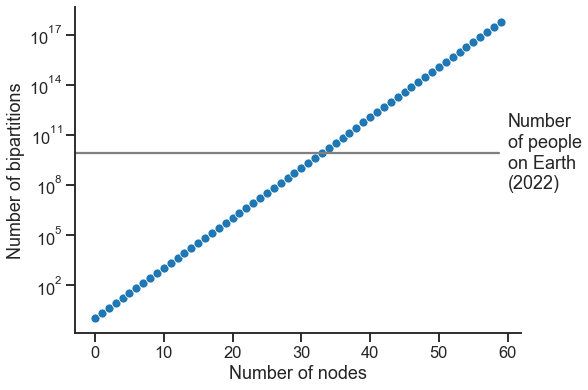

In [288]:
import numpy as np

ns = np.arange(60)

n_possible_taus = 2 ** ns

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(x=ns, y=n_possible_taus, ax=ax)
ax.set_yscale("log")
ax.set(xlabel="Number of nodes", ylabel="Number of bipartitions")
world_pop = 8_000_000_000
ax.axhline(world_pop, xmax=0.95, color="grey")
ax.text(60, world_pop, "Number\nof people\non Earth\n(2022)", va="center", ha="left")

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

```{admonition} Question
:class: tip

Let's say you have a network $A$, and I give you a random partition, $\tau$. What is the
silliest, most naive way you can think of trying to improve the modularity score?

```

For the next few examples, we'll use the "polbooks" dataset, available at 
[Netzschleuder](https://networks.skewed.de/net/polbooks#None_draw). Each node is a book,
and the nodes are linked by edges which represent "frequent copurchasing of those books
by the same buyers" on Amazon.

In [289]:
import networkx as nx
import pandas as pd

g = nx.read_edgelist("networks-course/data/polbooks.csv/edges.csv", delimiter=",")

nodelist = list(g.nodes)
node_df = pd.DataFrame(index=nodelist)

pos = nx.kamada_kawai_layout(g)

xs = []
ys = []
for node in nodelist:
    xs.append(pos[node][0])
    ys.append(pos[node][1])
xs = np.array(xs)
ys = np.array(ys)

node_df["x"] = xs
node_df["y"] = ys

adj = nx.to_numpy_array(g, nodelist=nodelist)
n = adj.shape[0]

node_df["degree"] = adj.sum(axis=0)

We'll start by generating a random $\tau$ with two communities.

In [290]:
# random bernoullis
rng = np.random.default_rng(888)
partition = rng.binomial(1, 0.5, size=n)

partition

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0])

Clearly this random partition of our network is not very good:

In [291]:
def modularity_from_adjacency(sym_adj, partition, resolution=1):
    if isinstance(partition, dict):
        partition_labels = np.vectorize(partition.__getitem__)(
            np.arange(sym_adj.shape[0])
        )
    else:
        partition_labels = partition
    partition_labels = np.array(partition_labels)
    in_comm_mask = partition_labels[:, None] == partition_labels[None, :]
    degrees = np.squeeze(np.asarray(sym_adj.sum(axis=0)))
    degree_prod_mat = np.outer(degrees, degrees) / sym_adj.sum()
    mod_mat = sym_adj - resolution * degree_prod_mat
    return mod_mat[in_comm_mask].sum() / sym_adj.sum()


mod_score = modularity_from_adjacency(adj, partition)
mod_score

-0.014078496099876065

What would this partition look like plotted on our network? 

(<Figure size 1080x504 with 4 Axes>,
 <AxesSubplot:xlabel='Number of nodes', ylabel='Number of bipartitions'>)

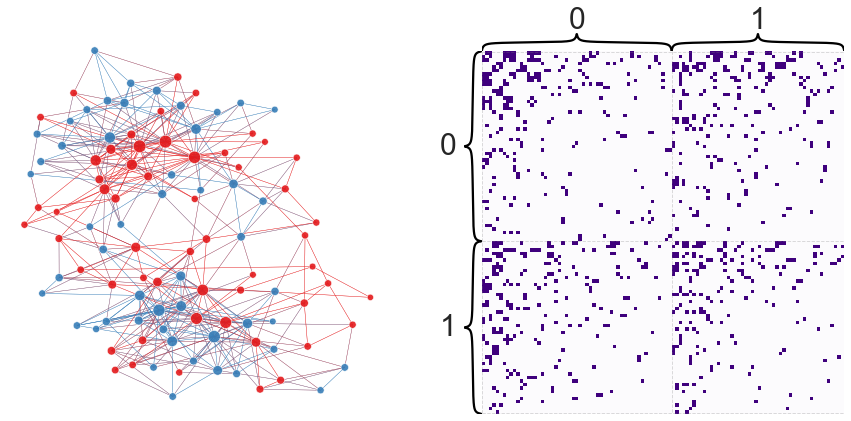

In [292]:
from graspologic.plot import networkplot, heatmap

node_df["random_partition"] = partition

def plot_network_partition(adj, node_data, partition_key):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    networkplot(
        adj,
        x="x",
        y="y",
        node_data=node_df.reset_index(),
        node_alpha=0.9,
        edge_alpha=0.7,
        edge_linewidth=0.4,
        node_hue=partition_key,
        node_size="degree",
        edge_hue="source",
        ax=axs[0],
    )
    _ = axs[0].axis("off")

    _ = heatmap(
        adj,
        inner_hier_labels=node_data[partition_key],
        ax=axs[1],
        cbar=False,
        cmap="Purples",
        vmin=0,
        center=None,
        sort_nodes=True,
    )

    return fig, ax

plot_network_partition(adj, node_df, 'random_partition')

Next we'll try a very simple algorithm for maximizing modularity. Starting from some 
initial partition $\tau_0$, we proceed by simply picking a node at random, and then 
check whether switching the group assigned to that node increases the modularity. If it
does, we move that node into that group. Otherwise, we revert it back to its original
group label, and proceed to the next iteration of checking another random node's label.

In [293]:
n_trials = 1000

best_scores = []
best_iterations = []
last_mod_score = mod_score
for iteration in range(n_trials):
    # choose a random node to perturb
    index = rng.choice(n)

    # check what group it is currently in, and swap it
    current_group = partition[index]
    if current_group:
        partition[index] = 0
    else:
        partition[index] = 1

    # compute modularity with this slightly modified partition
    mod_score = modularity_from_adjacency(adj, partition)

    # decide whether to keep that change or not
    if mod_score < last_mod_score:
        # swap it back
        if current_group:
            partition[index] = 1
        else:
            partition[index] = 0
    else:
        last_mod_score = mod_score
        best_scores.append(mod_score)
        best_iterations.append(iteration)

mod_score

0.4405468914701179

In [294]:
partition

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

Below, we look at how modularity changes as this simple algorithm progresses through
its iterations.

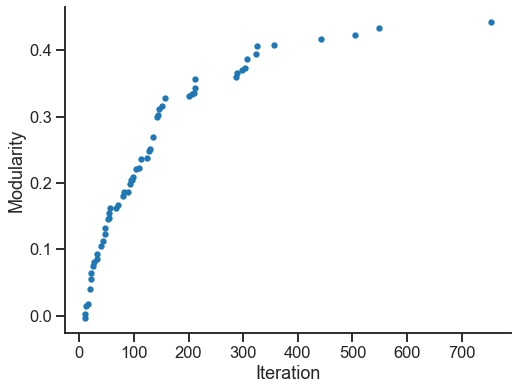

In [308]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(x=best_iterations, y=best_scores, ax=ax, s=40, linewidth=0)
ax.set(ylabel="Modularity", xlabel="Iteration")
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

Let's look at the partition we find when plotted over the network.

(<Figure size 1080x504 with 4 Axes>,
 <AxesSubplot:xlabel='Iteration', ylabel='Modularity'>)

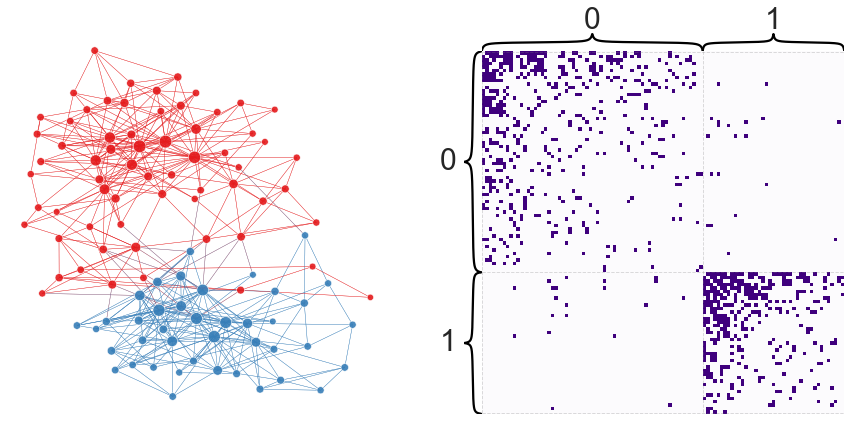

In [296]:
node_df["naive_partition"] = partition

plot_network_partition(adj, node_df, 'naive_partition')

### Spectral optimization

Next, we'll look at one less silly way of optimizing modularity. 

We can define the matrix $B$, often called the **modularity matrix** as 

$$B_{ij} = A_{ij} - \frac{k_i k_j}{2m} $$

Sticking to the case of two groups, let's change our convention for $\tau$ so that 
$\tau_i = 1$ if node $i$ is in group 1, and $\tau_i = -1$ if it is in group 2.

Then, note that our indicator function has a nice expression now:

$$\delta(\tau_i, \tau_j) = \frac{1}{2} (\tau_i \tau_j + 1)$$

Now we can easily write our modularity function. 

$$Q(A, \tau) = \frac{1}{4m} \sum_{ij} B_{ij} \tau_i \tau_j$$

In matrix/vector form, we can write this as 

$$Q(A, \tau) = \frac{1}{4m} \tau^T B \tau$$


Note that $B$ is still a symmetric matrix (since we were concerned with undirected graphs).

In [297]:
from graspologic.utils import is_symmetric

B = nx.modularity_matrix(g, nodelist=nodelist)

is_symmetric(B)

True

Next, we proceed by making an approximation. We have a discrete optimization problem:

$$\max_{\tau \text{ s.t. } \tau_i \in \{-1, 1\}} \tau^T B \tau$$

This is a difficult problem because of how many possible $\tau$s there are as we saw
before, and the discrete nature of the problem. Note that $\| \tau \|_2$, the Euclidean
norm of $\tau$, will always be $\sqrt{n}$. We relax our problem so that $\tau$ does not
have to be discrete, but keeps its length.

$$\max_{\tau \text{ s.t. } \| \tau \| = \sqrt{n}} \tau^T B \tau$$

This problem has the same solution (ignoring constants that don't affect the result besides
scaling):

$$R(B, \tau) = \max_{\tau} \frac{\tau^T B \tau}{\tau^T \tau}$$

Note that this expression is what's known as a 
[Rayleigh-Ritz ratio or Rayleigh quotient](https://en.wikipedia.org/wiki/Rayleigh_quotient). 
We won't go into deriving the properties of this, but note that if you know what an
eigendecomposition is, it is not to difficult to work out the following property: for a
symmetric matrix $B$ in the expression above, $R(B, \tau) \in [\lambda_{min}, \lambda_{max}]$ where
$\lambda_{min}$ and $\lambda_{max}$ are the smallest and largest eigenvalues of $B$, respectively.

So, this tells us that the maximum is achieved when $R(B, \tau) = \lambda_{max}$. And how 
can we achieve this upper bound? By setting $\tau$ to be the eigenvector corresponding
to the largest eigenvalue (call this $x$):

$$\frac{\tau^T B \tau}{\tau^T \tau} = \frac{x^T B x}{x^T x} = \frac{x^T \lambda_{max} x}{x^T x} = \lambda_{max} \frac{x^T  x}{x^T x} = \lambda_{max}$$

However, now we need to get back to our discrete optimization problem by projecting back onto
the discrete solutions, e.g. where $\tau$ is only $-1$ or $1$. To do so, we maximize the
inner products between this discrete solution, $\tau$, and our eigenvector $x$:

$$x^T \tau = \sum_i x_i \tau_i$$

To do so, we want $x_i \tau_i$ to be positive for all $i$. We can achieve this by 
setting 

$$
\tau_{i} = \begin{cases}
1 \text{   if } x_i > 0 \\
-1 \text{ if } x_i \leq 0
\end{cases}
$$

Thus, our simple algorithm is now to:
1. Compute the eigenvector corresponding to the largest eigenvalue of $B$, and
2. Threshold the corresponding eigenvector based on its sign to get our partition.

```{note}
Be careful about assuming the order in which eigenvalues/eigenvectors are returned.

Here, they are returned in *decreasing* order by the `eigh` function, which is faster
for symmetric (Hermitian) matrices.
```

In [298]:
eigenvalues, eigenvectors = np.linalg.eigh(B)
first_eigenvector = np.squeeze(np.asarray(eigenvectors[:, -1]))
first_eigenvector

array([-0.02550912, -0.02456848, -0.00170053, -0.19262125,  0.01632424,
       -0.02333085, -0.05243838,  0.01705257, -0.23826617, -0.14694971,
       -0.13066785, -0.17909148, -0.2278586 , -0.13652453, -0.09609015,
       -0.0537466 , -0.03258368, -0.07848085, -0.04078242, -0.02814099,
       -0.09584042, -0.07332282, -0.07773025, -0.11014213, -0.11975091,
       -0.05089722, -0.11127976, -0.12026225,  0.03486849, -0.03053454,
        0.18966993,  0.10967268, -0.07009965, -0.10030317, -0.08262   ,
       -0.03008297, -0.0535839 , -0.07084867, -0.06221648, -0.0758389 ,
       -0.1696462 , -0.10436962, -0.07279506, -0.04798468, -0.07367568,
       -0.08792768, -0.05454009, -0.17501516, -0.0219253 ,  0.01486383,
       -0.02666456, -0.00957711, -0.01668981, -0.03091357, -0.07826915,
       -0.03811773, -0.02425889, -0.02312067,  0.01822838,  0.04866926,
        0.02113664,  0.0199537 ,  0.04687952,  0.01967049,  0.02755088,
        0.01022675,  0.19268054,  0.03578428,  0.01618876,  0.00

In [299]:
eig_partition = first_eigenvector.copy()
eig_partition[eig_partition > 0] = 1
eig_partition[eig_partition <= 0] = 0
eig_partition = eig_partition.astype(int)

In [300]:
eig_partition

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

How does this partition compare to our earlier one?

(<Figure size 1080x504 with 4 Axes>,
 <AxesSubplot:xlabel='Iteration', ylabel='Modularity'>)

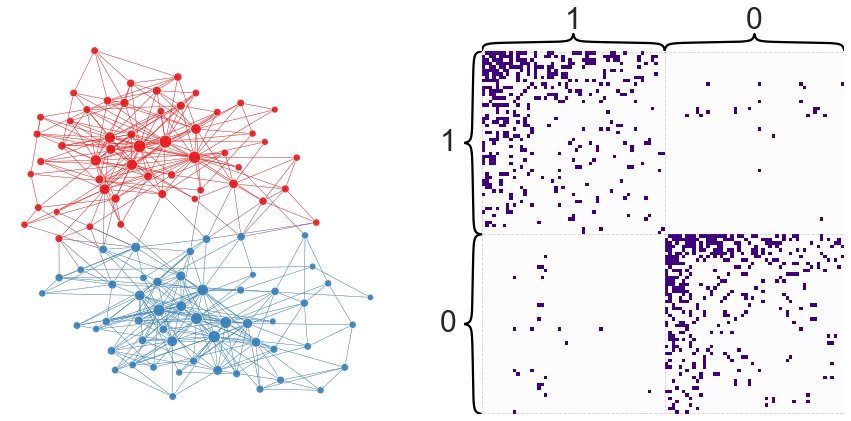

In [301]:
node_df["eig_partition"] = eig_partition

plot_network_partition(adj, node_df, 'eig_partition')

```{admonition} Question
:class:tip

Can you think of a simple way to combine the "naive" and spectral optimization approaches?
```

### Agglomerative optimization - Louvain/Leiden

We won't get into as much detail about more complicated methods for optimizing the 
modularity, but I wanted to mention these algorithms since they are somewhat 
state-of-the-art.

```{figure} ./images/louvain.png
---
name: louvain
---

High-level summary of the Louvain algorithm {cite}`blondel2008fast`. Figure from the 
Leiden paper {cite}`traag2019louvain`, which further improved the Louvain algorithm.
```

The Leiden algorithm scales to very large networks, and usually provides competitive 
modularity scores. It is easy to use from `graspologic`.

In [302]:
from graspologic.partition import leiden, modularity

leiden_partition_map = leiden(g)
type(leiden_partition_map)

dict

In [303]:
# this is necessary just because this modularity implementation assumes a weighted graph
nx.set_edge_attributes(g, 1, 'weight') 

modularity(g, leiden_partition_map)


0.5262287832744587

Note that this algorithm (like most) is not deterministic.

In [304]:
leiden_partition_map = leiden(g)
modularity(g, leiden_partition_map)

0.5262287832744587

Often, it's a good idea to take the best over multiple runs of the algorithm.

(<Figure size 1080x504 with 4 Axes>,
 <AxesSubplot:xlabel='Iteration', ylabel='Modularity'>)

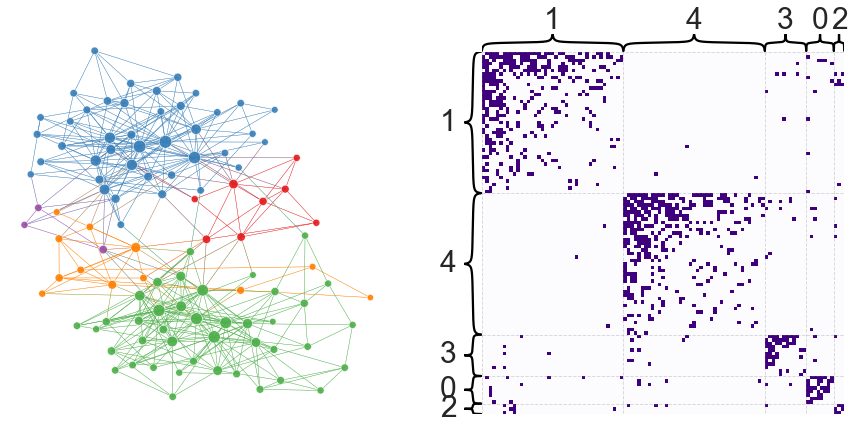

In [305]:
leiden_partition_map = leiden(g, trials=100)
modularity(g, leiden_partition_map)

node_df['leiden_partition'] = node_df.index.map(leiden_partition_map)

plot_network_partition(adj, node_df, 'leiden_partition')

### Know what modularity gives you

I briefly want to mention one point of confusion I've seen, in particular when thinking
about stochastic block models (SBM) and community detection. 

I always refer to community detection to mean "finding **assortative** or **homophillic**
groups of nodes." Both of these terms just mean "like connects to like." Conversely, 
other algorithms might be able to find **disassortative** groups of nodes, which I 
would not call communities.

Let's see how community detection performs in both of these cases.

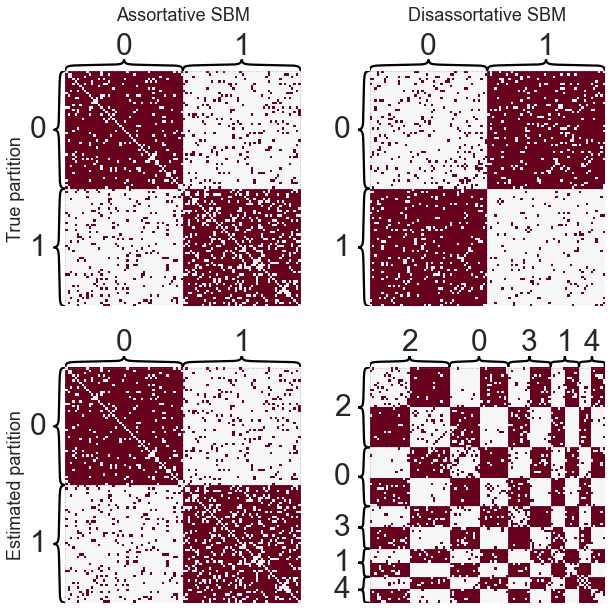

In [306]:
from graspologic.simulations import sbm 

B_assort = np.array([[0.9, 0.1], [0.1, 0.8]])
B_disassort = np.array([[0.1, 0.9], [0.9, 0.05]])

A_assort, labels_assort = sbm([50,50], B_assort, return_labels=True)
A_disassort, labels_disassort = sbm([50,50], B_disassort, return_labels=True)

nodelist = np.arange(100)

partition_map_assort = leiden(A_assort, trials=10)
partition_map_disassort = leiden(A_disassort, trials=10)
partition_assort = np.vectorize(partition_map_assort.get)(nodelist)
partition_disassort = np.vectorize(partition_map_disassort.get)(nodelist)

fig, axs = plt.subplots(2,2,figsize=(10,10))

heatmap_kws = dict(cbar=False)

ax = axs[0,0]
heatmap(A_assort, inner_hier_labels=labels_assort, ax=ax, **heatmap_kws)
ax.set_ylabel('True partition', labelpad=40)
ax.set_title('Assortative SBM', pad=50)

ax = axs[0,1]
heatmap(A_disassort, inner_hier_labels=labels_disassort, ax=ax, **heatmap_kws)
ax.set_title('Disassortative SBM', pad=50)

ax = axs[1,0]
heatmap(A_assort, inner_hier_labels=partition_assort, ax=ax, **heatmap_kws)
ax.set_ylabel('Estimated partition', labelpad=40)

ax = axs[1,1]
_ = heatmap(A_disassort, inner_hier_labels=partition_disassort, ax=ax, **heatmap_kws)


```{note}
Other families of algorithms *would* be able to find this disassortative 
partition - it's just not what modularity is looking for.
```

### Issues with modularity maximization

#### Resolution limit
While these algorithms are very useful, they have problems. The first is called the 
[resolution limit](https://en.wikipedia.org/wiki/Modularity_(networks)#Resolution_limit).
This idea is basically that for a large network, small communities (even if very clear)
can be impossible to detect for any modularity maximization algorithm. There is further
discussion of this issue in Section 14.2.6 of Newman's Networks book.

#### Overfitting
Modularity maximization algorithms can also have the converse problem, that is, finding
community structure when it is not present. This is best demonstrated by example.

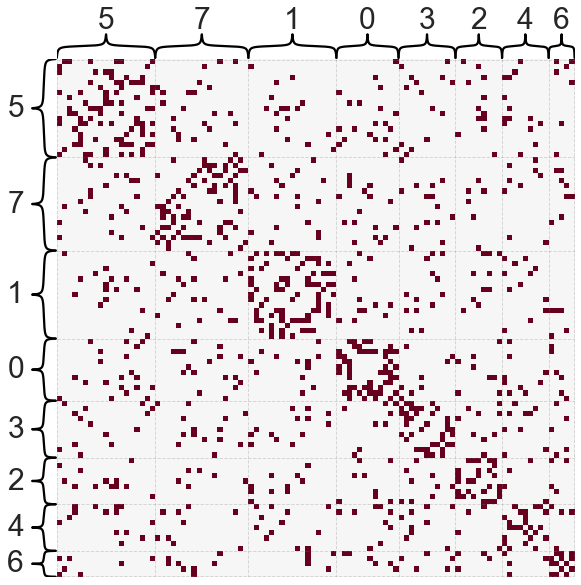

In [307]:
from graspologic.simulations import er_np

n_nodes = 100

A_er = er_np(n_nodes, 0.1)

leiden_partition_map = leiden(A_er)

nodes = np.arange(n_nodes)
partition_labels = np.vectorize(leiden_partition_map.get)(nodes)

_ = heatmap(A_er, inner_hier_labels=partition_labels, cbar=False)

Even for this very simple, completely random (Erdos-Renyi) network, Leiden found several
communities - further, these communities *do* look more densely connected within. 
However, the key point here is that these "communities" arose completely by chance even
with the simplest null model.

## Alternatives to modularity

While we haven't had time to discuss them, there are many alternatives to modularity
maximization for finding communities. For instance:

### InfoMap
InfoMap uses random walks and an information theory framework. The idea is
that good communities should allow you to easily compress the amount of information that
would be required to encode the path of a random walker.

```{figure} ./images/metadatamapequation.svg
Illustration of the idea of encoding the path of random walkers used by InfoMap.
Figure from {cite:t}`emmons2019map`.
```

### Statistical inference (SBM + similar)
```{figure} ./images/peixoto-community.png
Demonstration of how inferring a statistical model (like an assortative SBM) can 
alleviate some of the issues from modularity maximization. Figure from {cite:t}`peixoto2021descriptive`.
```

## Other code
- [CDlib](https://cdlib.readthedocs.io/en/latest/) has a wide range of community detection algorithms.
- [NetworkX's community section](https://networkx.org/documentation/stable/reference/algorithms/community.html) has a few algorithms.
- [graph-tool](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html#assortative-community-structure) has some new tools for assortative community detection based on statistical models.

## References 
```{bibliography}
:filter: docname in docnames
:style: unsrt
```